In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
#os.environ['PROJ_LIB'] = r'C:/Users/mastr/miniconda3/pkgs/proj4-5.2.0-ha925a31_1/Library/share'     ## Windows OS
os.environ['PROJ_LIB'] = r'/Users/mmastro/miniconda3/pkgs/proj4-5.2.0-ha925a31_1/Library/share'     ## Mac OS
import glob
import netCDF4 as nc
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy as cart
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker


In [2]:
## Function for creating a path, if needed ##
def checkDir(out_path):
    if not os.path.exists(out_path):
        os.makedirs(out_path)


def detrend_dim(da, dim, degree):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=degree)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    da_det = (da - fit)
    return da_det

def cell_weight(ds):
    R = 6.371e6
    dϕ = np.deg2rad(ds.lat[1] - ds.lat[0])
    dλ = np.deg2rad(ds.lon[1] - ds.lon[0])
    dlat = R * dϕ * xr.ones_like(ds.lon)
    dlon = R * dλ * np.cos(np.deg2rad(ds.lat))
    cell_area = dlon * dlat
    return(cell_area)

def xr_mean_list(xr_list, nc_files):
    ## Function for calculate the mean response of several simulations from different ESM
    # xr_list: list of xarray, each representing one simulation 
    # nc_files: list of NetCDF opened with nc.Dataset(), containing data and attributes
    # returns an xr_list_new with one element for each esm 

    # List of ESM names in every simulation
    esm = [a for a in nc_files]

    # Assign as a new coordinate ESM name
    xr_list = [a.assign_coords(esm=b) for a,b in zip(xr_list,esm)]

    # List of unique ESM names sorted
    esm = list(set(esm))
    esm.sort()

    # Create a list of the different esm lists
    access = []; bcc = []; cesm = []; cmcc = []; cnrm = []; canesm = []; e3sm = []; ipsl = []; miroc = []; mpi = []; noresm = []; taiesm = []; ukesm = []
    esm_list = [access, bcc, cesm, cmcc, cnrm, canesm, e3sm, ipsl, miroc, mpi, noresm, taiesm, ukesm]

    # populate the esm_list according to xr.coords["esm"]
    for e,model in enumerate(esm):
        for i,xarray in enumerate(xr_list):
            esm_coord = xarray.coords["esm"]
            if esm_coord == esm[e]:
                esm_list[e].append(xarray)

    # take the mean of all the xarray belonging to the same esm
    xr_list_new = []
    for e in esm_list:
        content = xr.concat(e, dim='realiz')
        content1 = content.mean(dim = "realiz")
        xr_list_new.append(content1)
    
    return xr_list_new

def xr_esm_list(xr_list, nc_files):
    ## Function for calculate the mean response of several simulations from different ESM
    # xr_list: list of xarray, each representing one simulation 
    # nc_files: list of NetCDF opened with nc.Dataset(), containing data and attributes
    # returns an xr_list_new with one element for each esm 

    # List of ESM names in every simulation
    esm = [a for a in nc_files]

    # Assign as a new coordinate ESM name
    xr_list = [a.assign_coords(esm=b) for a,b in zip(xr_list,esm)]

    # List of unique ESM names sorted
    esm = list(set(esm))
    esm.sort()

    # Create a list of the different esm lists
    access = []; bcc = []; cesm = []; cmcc = []; cnrm = []; canesm = []; e3sm = []; ipsl = []; miroc = []; mpi = []; noresm = []; taiesm = []; ukesm = []
    esm_list = [access, bcc, cesm, cmcc, cnrm, canesm, e3sm, ipsl, miroc, mpi, noresm, taiesm, ukesm]

    # populate the esm_list according to xr.coords["esm"]
    for e,model in enumerate(esm):
        for i,xarray in enumerate(xr_list):
            esm_coord = xarray.coords["esm"]
            if esm_coord == esm[e]:
                esm_list[e].append(xarray)

    # take the mean of all the xarray belonging to the same esm
    xr_list_new = []
    for e in esm_list:
        content = xr.concat(e, dim='realiz')
        # content1 = content.mean(dim = "realiz")
        xr_list_new.append(content)
    
    return xr_list_new 

In [3]:
# -- Path for netcdf files
data_path = 'C:/Users/mastr/Documents/Amazon'

# -- Path for the output files (images, etc)
out_path = 'C:/Users/mastr/Documents/Amazon/RESULTS'
out_path = 'G:/Shared drives/Amazon_ENSO_work/RESULTS'

# -- Create directories
checkDir(data_path)
checkDir(out_path)

## HadISST

In [4]:
####======= Open Nino data =======####
data_path = 'F:/Data/Reanalysis/hadsst/'
files = 'HadISST_sst.nc' 

ds_obs = xr.open_dataarray(os.path.join(data_path+files), drop_variables=["time_bnds","lon_bnds","lat_bnds"]); #ds_obs = ds_obs.mean(axis=0)
ds_obs = ds_obs.where(ds_obs != -1000.)  ## Replace -1000 (sea ice) with nan
ds_obs = ds_obs.rename({"longitude":"lon"}); ds_obs = ds_obs.rename({"latitude":"lat"})

# Invert lat values from 89.5,-89.5 to -89.5,89.5
ds_obs = ds_obs.reindex(lat=ds_obs.lat[::-1])   
# Change starting lon value from -179.5 to -180
ds_obs = ds_obs.assign_coords(lon=(ds_obs.lon - 0.5))
# ds_obs = ds_obs.roll(lon = 180, roll_coords=True)

cell_area_obs = cell_weight(ds_obs)

nino34_obs = (ds_obs.sel(lat = slice(-5, 5), lon = slice(-170, -120)).weighted(cell_area_obs).mean(["lat", "lon"]).groupby('time.month') - 
    ds_obs.sel(lat = slice(-5, 5), lon = slice(-170, -120)).sel(time= slice("1981-01", "2010-12")).groupby('time.month').mean('time').weighted(cell_area_obs).mean(["lat", "lon"])).compute(dim="sst").rolling(time = 5, center = True).mean()


nino34_obs = detrend_dim(nino34_obs, "time", 1)

In [5]:
# PSD (Welch method)

from scipy import signal
from scipy.signal import argrelextrema

# Normalization
nino34_obs_norm = ((nino34_obs - (nino34_obs.mean(dim='time'))).compute()/(nino34_obs.std(dim='time'))).compute()

# PSD computation
f_obs, Pxx_den_obs = signal.welch(nino34_obs.dropna("time"), fs=1)

# Find local maxima
ex_nino_obs = argrelextrema(Pxx_den_obs, np.greater)


## ESM

In [6]:
# Open SST data

data_path = 'C:/Users/mastr/Documents/Amazon'
scenario = 'historical'
files = "nino34" + '_*_' + scenario + '_*'

nino34_hist = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/ENSO/detrended/'+files))):               # sorted is case sensitive                             ## List of files sorted by name
    content = xr.open_dataset(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"]); #content = content.mean(dim="time")         ## values   var     dims    coords
    nino34_hist.append(content)

scenario = 'ssp585'
files = "nino34" + '_*_' + scenario + '_*' 

nino34_ssp = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/ENSO/detrended/'+files))):               # sorted is case sensitive                             ## List of files sorted by name
    content = xr.open_dataset(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"]); #content = content.mean(dim="time")         ## values   var     dims    coords
    nino34_ssp.append(content)

# Standardize calendar 
for i, item in enumerate(nino34_hist):
    if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
        nino34_hist[i]['time'] = item.indexes['time'].to_datetimeindex()
    
for i, item in enumerate(nino34_ssp):
    if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
        nino34_ssp[i]['time'] = item.indexes['time'].to_datetimeindex()

# Convert to dataarray

nino34_hist = [a.to_array() for a in nino34_hist]
nino34_ssp = [a.to_array() for a in nino34_ssp]

In [7]:
# Retrieve esm attributes
data_path = 'F:/Data/analysis/'              
var_name = 'tos'
scenario = 'historical'
files = var_name + '_*_' + scenario + '_*_' + 'remap.nc' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+scenario+"/"+files))):               # List of files sorted by name
        content = nc.Dataset(filepath).source_id
        files_list.append(content)   

esm = list(sorted(set(files_list)))

### ENSO Amplitude 

In [8]:
# ENSO Amplitude (Std.Dev.)

nino34_obs_std = nino34_obs.std()
nino34_hist_std = [a.std() for a in nino34_hist]
nino34_ssp_std = [a.std() for a in nino34_ssp]

# Mediate the response for the esm

nino34_hist_std = xr_mean_list(nino34_hist_std,files_list)
nino34_ssp_std = xr_mean_list(nino34_ssp_std,files_list)


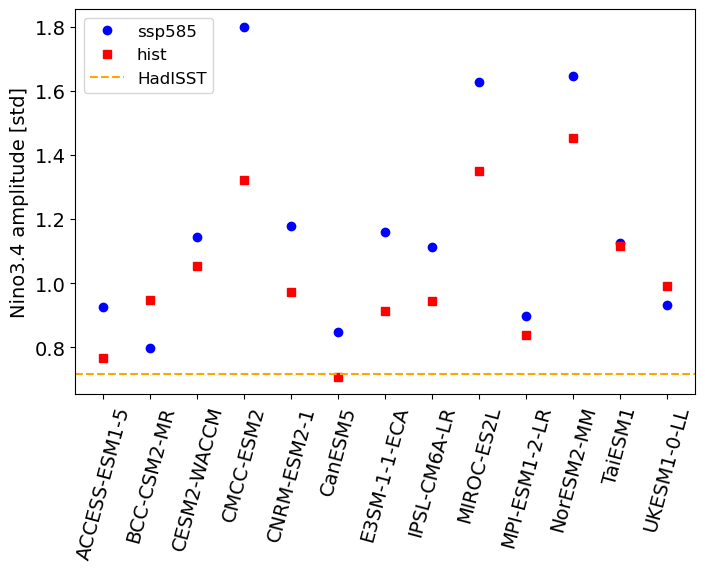

In [124]:
# Plot configuration
width_inch = 8
height_inch = 5     

# Title label
title = 'ENSO Amplitude' + ", ssp585 - " + "historical"
# Title fontsize
title_fontstyle = {
    "fontsize": "20",
    "pad": 20
}

# Axes labels
ylabel = 'Nino3.4 amplitude [std]'
xlabelpad = 15
ylabelpad = 10     

###================== SINGLE PLOT ================####
plt.figure(figsize=(width_inch, height_inch))

for i, item in enumerate(nino34_hist_std):          
    
    plt.plot(esm[i], nino34_ssp_std[i], "o", color = 'blue', label='ssp585')
    plt.plot(esm[i], nino34_hist_std[i], "s", color = 'red', label='hist')
    plt.ylabel(ylabel, fontsize=14)
    plt.tick_params(labelsize=14)
    plt.xticks(rotation = 75)
plt.axhline(nino34_obs_std, color = 'orange', linestyle = "dashed", label = "HadISST")

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
# plt.ylim(0.2, 1.7)
plt.legend(by_label.values(), by_label.keys(), fontsize=12, loc = "upper left")

# plt.title(title, **title_fontstyle)

# output file
output_file = os.path.join(out_path,title.replace(' ','_')) + ".png"
# save the output file
# plt.savefig(output_file, bbox_inches='tight')
plt.show()
plt.close()

In [89]:
labels

['nino34_ssp',
 'nino34_hist',
 'nino34_ssp',
 'nino34_hist',
 'nino34_ssp',
 'nino34_hist',
 'nino34_ssp',
 'nino34_hist',
 'nino34_ssp',
 'nino34_hist',
 'nino34_ssp',
 'nino34_hist',
 'nino34_ssp',
 'nino34_hist',
 'nino34_ssp',
 'nino34_hist',
 'nino34_ssp',
 'nino34_hist',
 'nino34_ssp',
 'nino34_hist',
 'nino34_ssp',
 'nino34_hist',
 'nino34_ssp',
 'nino34_hist',
 'nino34_ssp',
 'nino34_hist']

In [ ]:
# Plot configuration
width_inch = 8
height_inch = 5     

# Title label
title = 'ENSO Amplitude' + ", ssp585 - " + "historical"
# Title fontsize
title_fontstyle = {
    "fontsize": "20",
    "pad": 20
}

# Axes labels
ylabel = 'Nino3.4 amplitude [std]'
xlabelpad = 15
ylabelpad = 10     

###================== SINGLE PLOT ================####
plt.figure(figsize=(width_inch, height_inch))

for i, item in enumerate(nino34_ssp_std):
    for e, realiz in enumerate(nino34_ssp_std[i]):         
    
        plt.plot(esm[i], nino34_ssp_std[i][e], "o", color = 'blue', label='nino34_ssp')
        plt.plot(esm[i], nino34_hist_std[i][e], "s", color = 'red', label='nino34_hist')
        plt.ylabel(ylabel, fontsize=14)
        plt.tick_params(labelsize=14)
        plt.xticks(rotation = 75)

handles, labels = bplot.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), fontsize=12, loc = "upper left")
# plt.title(title, **title_fontstyle)

# output file
output_file = os.path.join(out_path,title.replace(' ','_')) + ".png"
# save the output file
# plt.savefig(output_file, bbox_inches='tight')
plt.show()
plt.close()

### ENSO PSD (Welch method) 

In [ ]:
# PSD (Welch method)

from scipy import signal
from scipy.signal import argrelextrema

# Normalization
nino34_hist_norm = [((a - (a.mean(dim='time'))).compute()/(a.std(dim='time'))).compute() for a in nino34_hist]
nino34_ssp_norm = [((a - (a.mean(dim='time'))).compute()/(a.std(dim='time'))).compute() for a in nino34_ssp]

# PSD computation
f_hist=[]; Pxx_den_hist=[]
for i,item in enumerate(nino34_hist_norm):
    content1, content2 = signal.welch(item.dropna("time"), fs=1)
    f_hist.append(content1)
    Pxx_den_hist.append(content2)

f_ssp=[]; Pxx_den_ssp=[]
for i,item in enumerate(nino34_ssp_norm):
    content1, content2 = signal.welch(item.dropna("time"), fs=1)
    f_ssp.append(content1)
    Pxx_den_ssp.append(content2)

# Find local maxima
ex_nino_hist=[]
for i,item in enumerate(Pxx_den_hist):
    content = argrelextrema(item, np.greater)
    ex_nino_hist.append(content)

ex_nino_ssp=[]
for i,item in enumerate(Pxx_den_ssp):
    content = argrelextrema(item, np.greater)
    ex_nino_ssp.append(content)


# Mediate the response for the esm

f_hist = xr_mean_list(xr.DataArray(f_hist),files_list)
f_ssp = xr_mean_list(xr.DataArray(f_ssp),files_list)
Pxx_den_hist = xr_mean_list(xr.DataArray(Pxx_den_hist),files_list)
Pxx_den_ssp = xr_mean_list(xr.DataArray(Pxx_den_ssp),files_list)
ex_nino_hist = xr_mean_list(xr.DataArray(ex_nino_hist),files_list)
ex_nino_ssp = xr_mean_list(xr.DataArray(ex_nino_ssp),files_list)

In [ ]:
# Plot configuration
width_inch = 12
height_inch = 8

# Title label
title="Power Spectrum Density" + ", ssp585"

fig = plt.figure(figsize=(width_inch, height_inch)) #, constrained_layout=True)
gs = gridspec.GridSpec(4, 8)


# Iteratively create subplots 
for i, ax in enumerate(esm):

    if i < 4:
        ax = fig.add_subplot(gs[0, 2 * i : 2 * i + 2])
    if ((i > 3) and (i < 8)):
        ax = fig.add_subplot(gs[1, 2 * i - 8 : 2 * i - 6])
    if ((i > 7) and (i < 12)):
        ax = fig.add_subplot(gs[2, 2 * i - 16 : 2 * i -14])
    if i > 11:
        ax = fig.add_subplot(gs[3, 2 * i - 21 : 2 * i -19])

    ax.plot(f_obs, Pxx_den_obs, color = "blue", label = "HadISST")
    ax.plot(f_hist[i], Pxx_den_hist[i][0], color = "green", label="hist")
    ax.plot(f_ssp[i], Pxx_den_ssp[i][0], color = "orange", label="ssp585")

    ax.set_xlim(0,0.1)
    ax.set_ylim(-2, 65)
    #ax.set_xlabel('frequency [mon$^{-1}$]')
    #ax.set_ylabel('PSD') 

    ax1 = ax.twiny()
    ax1.set_xlim(ax.get_xlim())
    new_tick_locations = np.array([1/(12*10), 1/(12*5), 1/(12*3), 1/(12*2), 1/(12*1)]) #ax.get_xticks()
    def tick_function(X):
        V = 1/X/12
        return ["%.3f" % z for z in V]

    years = tick_function(new_tick_locations)
    years = np.round(np.float16(years), 0)
    years = np.int64(years)
    ax1.set_xticklabels(years)
    ax1.set_xticks(new_tick_locations)
    ax1.set_xlabel('period [years]', labelpad = 5)

    ax1.grid()
    ax.tick_params(axis='both', labelsize=12 ) 
    ax.label_outer()
    ax1.label_outer()
    ax.set_title(esm[i],fontsize=14)  

fig.supxlabel('frequency [mon$^{-1}$]')
fig.supylabel('PSD')
# fig.suptitle(title, fontsize = 20)
ax.legend(loc='upper right',bbox_to_anchor=(1., 0.9),fontsize=10)

fig.subplots_adjust(bottom=0.2, top=0.95, left=0.1, right=0.8, wspace=0.0, hspace=0.25)
fig.tight_layout()

output_file = os.path.join(out_path,title) + ".png"
# plt.savefig(output_file)
plt.show()
plt.close()

### ENSO Wavelet transform

Continuous Wavelet transform

In [30]:
# CWT (Morlet)

from scipy import signal
import pycwt as wavelet
from pycwt.helpers import find

def cont_wavelet_trans(ds,ω0):
    dt = 1/12  # In years
    N = (ds.dropna("time").to_numpy().size)
    t0 = ds.dropna("time").time.dt.year[0].values
    tn = ds.dropna("time").time.dt.year[-1].values
    t = np.int64(np.arange(0, N) * dt + t0)

    ## -- Define he mother wavelet, in this case the Morlet wavelet with ω0=6 -- ##
    mother = wavelet.Morlet(ω0)
    s0 = 6 * dt  # Starting scale, in this case 2 * 1/4 years = 6 months
    dj = 1 / 12  # Twelve sub-octaves per octaves
    J = 7 / dj  # Seven powers of two with dj sub-octaves
    alpha, _, _ = wavelet.ar1(ds.dropna("time").to_numpy()[0])  # Lag-1 autocorrelation for red noise

    ## -- Perform the wavelet transform and inverse wavelet transform
    wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(ds.dropna("time").to_numpy()[0], dt, dj, s0, J, mother)
    iwave = wavelet.icwt(wave, scales, dt, dj, mother) * np.std(ds.dropna("time").to_numpy()[0])

    ## -- Calculate the normalized wavelet and Fourier power spectra, as well as the Fourier equivalent periods for each wavelet scale.
    power = (np.abs(wave)) ** 2
    fft_power = np.abs(fft) ** 2
    period = 1 / freqs

    ## -- Power spectra significance test. The power is significant where the ratio power / sig95 > 1
    signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha, significance_level=0.95, wavelet=mother)
    sig95 = np.ones([1, N]) * signif[:, None]
    sig95 = power / sig95

    ## -- Calculate the global wavelet spectrum and determine its significance level.
    glbl_power = power.mean(axis=1)
    dof = N - scales  # Correction for padding at edges
    glbl_signif, tmp = wavelet.significance(np.var(ds.dropna("time").to_numpy()[0]), dt, scales, 1, alpha,significance_level=0.95, dof=dof,wavelet=mother)

    ## -- Calculate the scale average between 2 years and 8 years, and its significance level.
    sel = find((period >= 2) & (period < 8))
    Cdelta = mother.cdelta
    scale_avg = (scales * np.ones((N, 1))).transpose()
    scale_avg = power / scale_avg  # As in Torrence and Compo (1998) equation 24
    scale_avg = np.var(ds.dropna("time").to_numpy()) * dj * dt / Cdelta * scale_avg[sel, :].sum(axis=0)
    scale_avg_signif, tmp = wavelet.significance(np.var(ds.dropna("time").to_numpy()), dt, scales, 2, alpha,
                                                significance_level=0.95,
                                                dof=[scales[sel[0]],
                                                    scales[sel[-1]]],
                                                wavelet=mother)

    # Second sub-plot, the normalized wavelet power spectrum and significance
    # level contour lines and cone of influece hatched area. Note that period
    # scale is logarithmic.
    levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
    extent = [t0, tn, 0, max(period)]
    coi_fixed = np.log2(coi)
    coi_fixed[np.log2(coi)<0] = 0

    #ax.fill(np.concatenate([t, t[-1:] + dt, t[-1:] + dt,t[:1] - dt, t[:1] - dt]),
    #            np.concatenate([np.log2(coi), [1e-9], np.log2(period[-1:]), np.log2(period[-1:]), [1e-9]]), 'k', alpha=0.3, hatch='x') 
    
    return t,period,sig95,coi_fixed,power

t_hist = []
period_hist = []
sig95_hist = []
coi_fixed_hist = []
power_hist = []
for i, item in enumerate(nino34_hist):
    t,period,sig95,coi_fixed,power = cont_wavelet_trans(nino34_hist[i],6)
    t_hist.append(t)
    period_hist.append(period)
    sig95_hist.append(sig95)
    coi_fixed_hist.append(coi_fixed)
    power_hist.append(power)

t_ssp = []
period_ssp = []
sig95_ssp = []
coi_fixed_ssp = []
power_ssp = []
for i, item in enumerate(nino34_ssp):
    t,period,sig95,coi_fixed,power = cont_wavelet_trans(nino34_ssp[i],6)
    t_ssp.append(t)
    period_ssp.append(period)
    sig95_ssp.append(sig95)
    coi_fixed_ssp.append(coi_fixed)
    power_ssp.append(power)


# Mediate the response for the esm

t_hist = xr_mean_list(xr.DataArray(t_hist),files_list)
period_hist = xr_mean_list(xr.DataArray(period_hist),files_list)
sig95_hist = xr_mean_list(xr.DataArray(sig95_hist),files_list)
coi_fixed_hist = xr_mean_list(xr.DataArray(coi_fixed_hist),files_list)
t_ssp = xr_mean_list(xr.DataArray(t_ssp),files_list)
period_ssp = xr_mean_list(xr.DataArray(period_ssp),files_list)
sig95_ssp = xr_mean_list(xr.DataArray(sig95_ssp),files_list)
coi_fixed_ssp = xr_mean_list(xr.DataArray(coi_fixed_ssp),files_list)

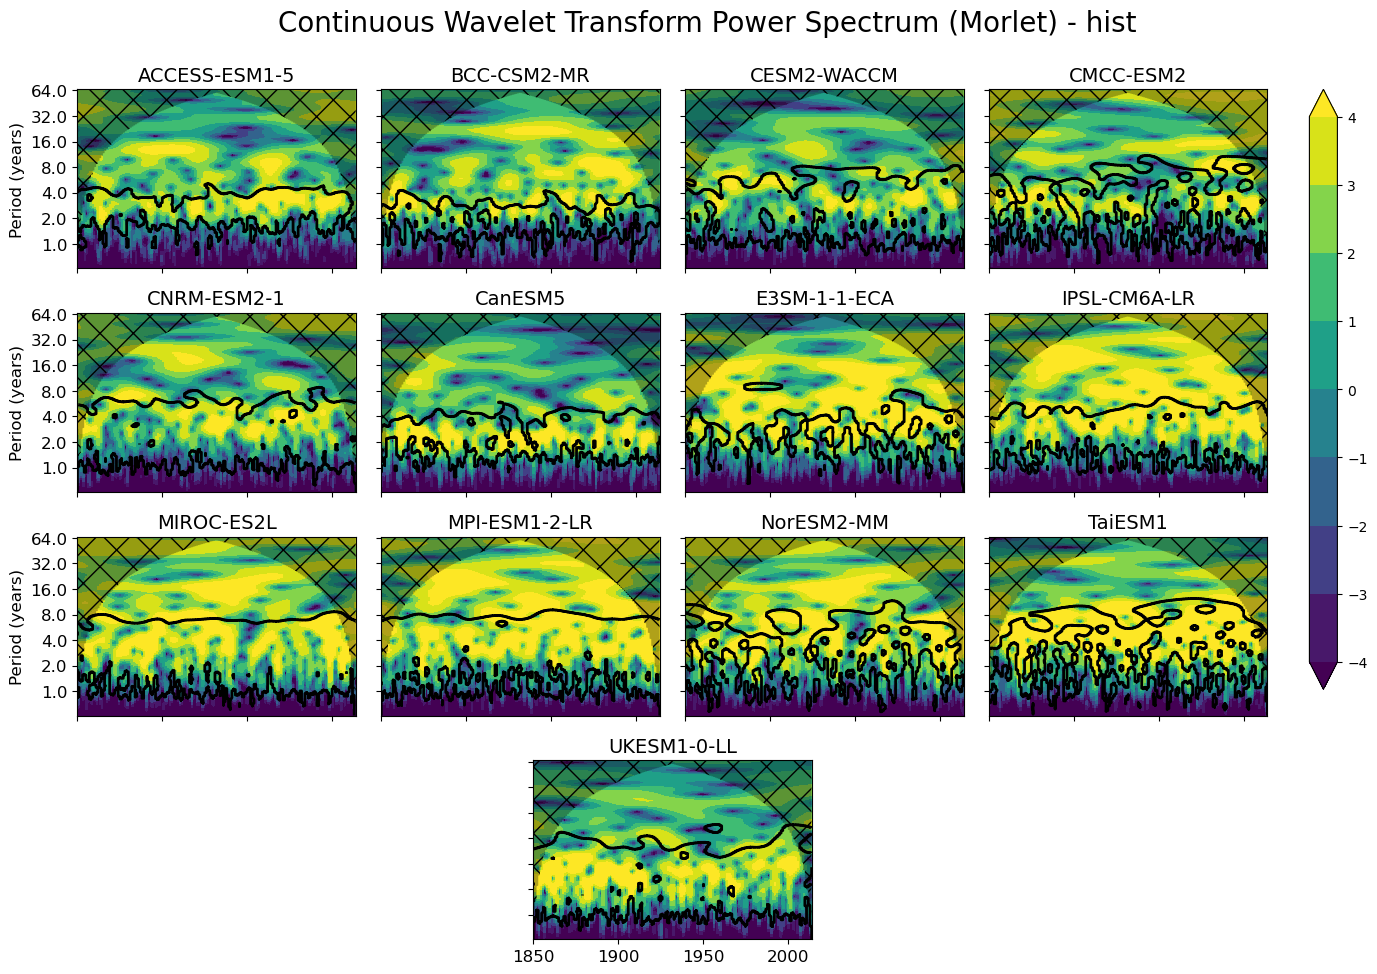

In [40]:
# Plot Continuous Wavelet Transform

width_inch = 14
height_inch = 10

fig = plt.figure(figsize=(width_inch, height_inch)) #, constrained_layout=True)
gs = gridspec.GridSpec(4, 8)

for i, ax in enumerate(esm):

    if i < 4:
        ax = fig.add_subplot(gs[0, 2 * i : 2 * i + 2])
    if ((i > 3) and (i < 8)):
        ax = fig.add_subplot(gs[1, 2 * i - 8 : 2 * i - 6])
    if ((i > 7) and (i < 12)):
        ax = fig.add_subplot(gs[2, 2 * i - 16 : 2 * i -14])
    if i > 11:
        ax = fig.add_subplot(gs[3, 2 * i - 21 : 2 * i -19])

    dt = 1/12  # In years
    N = (nino34_hist[i].dropna("time").to_numpy().size)
    t0 = nino34_hist[i].dropna("time").time.dt.year[0].values
    tn = nino34_hist[i].dropna("time").time.dt.year[-1].values
    levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
    cwt = ax.contourf(t_hist[i], np.log2(period_hist[i]), np.log2(power_hist[i]), np.log2(levels), extend='both')
    extent = [t0, tn, 0, max(period_hist[i])]
    ax.contour(t_hist[i], np.log2(period_hist[i]), sig95_hist[i], [-99, 1], colors='k', linewidths=2, extent=extent)

    #ax.fill(np.concatenate([t, t[-1:] + dt, t[-1:] + dt,t[:1] - dt, t[:1] - dt]),
    #            np.concatenate([np.log2(coi), [1e-9], np.log2(period[-1:]), np.log2(period[-1:]), [1e-9]]), 'k', alpha=0.3, hatch='x') 
    ax.fill(np.concatenate([t_hist[i], t_hist[i][-1:]-2*dt, t_hist[i][-1:]-2*dt,t_hist[i][:1], t_hist[i][:1]]),
                np.concatenate([coi_fixed_hist[i], [1e-9], np.log2(period_hist[i][-1:]), np.log2(period_hist[i][-1:]), [1e-9]]), 'k', alpha=0.3, hatch='x')
    ax.set_title(esm[i],fontsize=14)
    ax.set_ylabel('Period (years)', size = 12)
        
    Yticks = 2 ** np.arange(np.ceil(np.log2(period_hist[i].min())), np.ceil(np.log2(period_hist[i].max())))
    ax.set_yticks(np.log2(Yticks))
    ax.set_yticklabels(Yticks, size = 12)
    ax.set_xticklabels(np.int64(np.arange(t_hist[i].min(),t_hist[i].max(),50)), size = 12)
    ax.label_outer()

    # Third sub-plot, the global wavelet and Fourier power spectra and theoretical
    # noise spectra. Note that period scale is logarithmic.
    #cx = plt.axes([0.77, 0.37, 0.2, 0.28], sharey=ax)
    #cx.plot(glbl_signif, np.log2(period), 'k--')
    #cx.plot(np.var(nino34_hist[i].dropna("time").to_numpy()) * fft_theor, np.log2(period), '--', color='#cccccc')
    #cx.plot(np.var(nino34_hist[i].dropna("time").to_numpy()) * fft_power, np.log2(1./fftfreqs), '-', color='#cccccc',
    #        linewidth=1.)
    #cx.plot(np.var(nino34_hist[i].dropna("time").to_numpy()) * glbl_power, np.log2(period), 'k-', linewidth=1.5)
    #cx.set_title('c) Global Wavelet Spectrum')
    #cx.set_xlabel(r'Power [({})^2]'.format(units))
    #cx.set_xlim([0, glbl_power.max() + np.var(nino34_hist[i].dropna("time").to_numpy())])
    #cx.set_ylim(np.log2([period.min(), period.max()]))
    #cx.set_yticks(np.log2(Yticks))
    #cx.set_yticklabels(Yticks)
    #plt.setp(cx.get_yticklabels(), visible=False)

#fig.subplots_adjust(bottom=0.2, top=0.90, left=0.1, right=0.7, wspace=0.0, hspace=0.25)
# fig.tight_layout()
cbar_ax = fig.add_axes([0.93, 0.3, 0.02, 0.6])                     # Left, Bottom, Width, Height
clb = fig.colorbar(cwt, cax=cbar_ax, extend="both")

title = 'Continuous Wavelet Transform Power Spectrum ({})'.format(wavelet.Morlet().name) + " - hist"

fig.suptitle(title, fontsize = 20) 
fig.subplots_adjust(bottom=0.05, top=0.9, left=0.05, right=0.9, wspace=0.2, hspace=0.25)
output_file = os.path.join(out_path,title) + "_nino34.png"
plt.savefig(output_file)
plt.show()
plt.close()

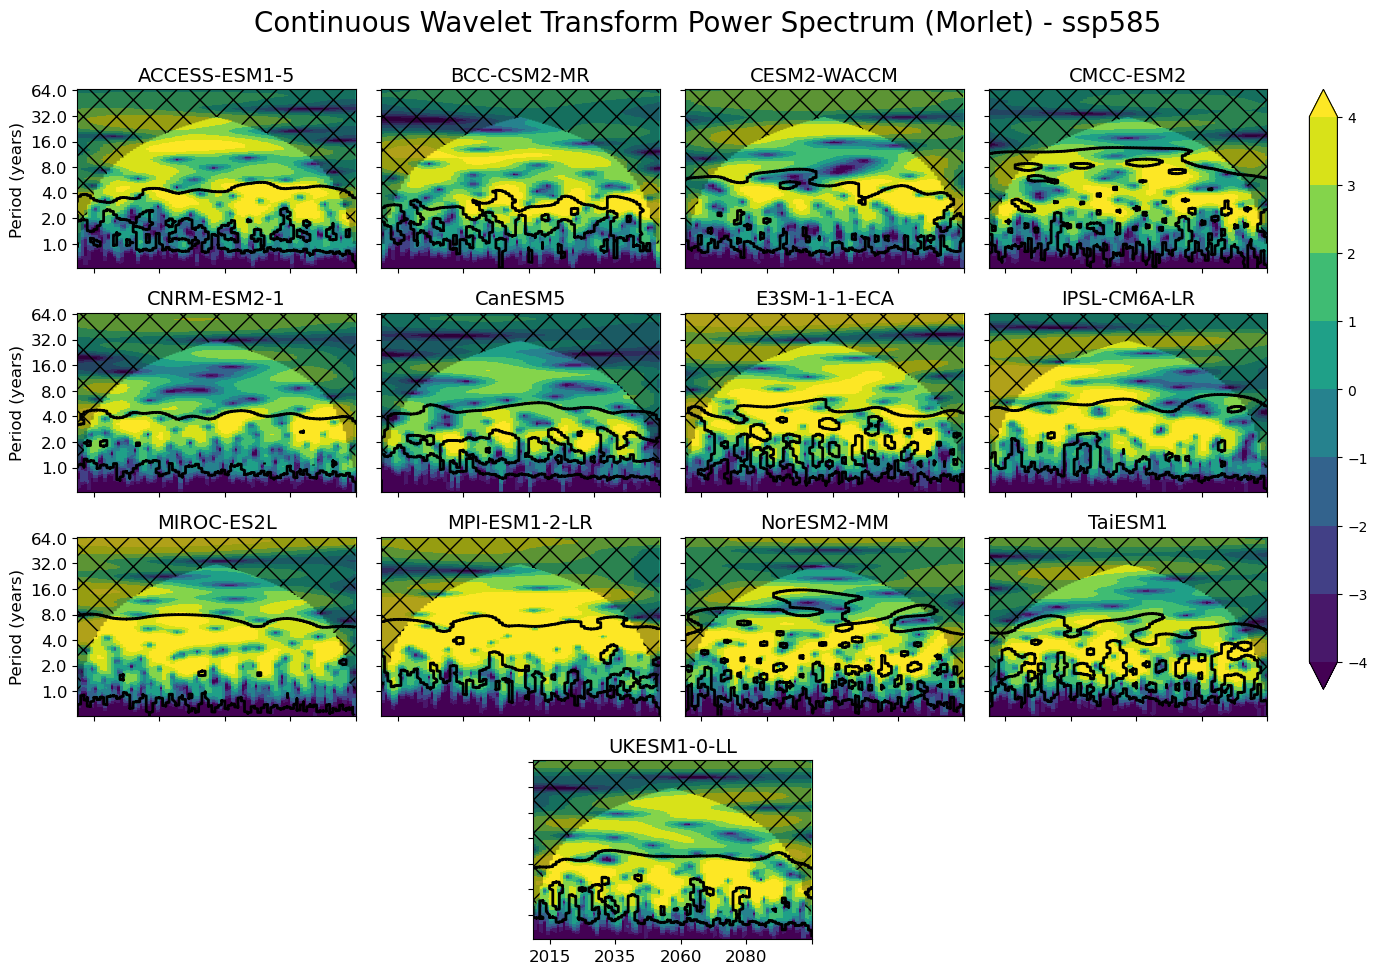

In [56]:
# Plot Continuous Wavelet Transform

width_inch = 14
height_inch = 10

fig = plt.figure(figsize=(width_inch, height_inch)) #, constrained_layout=True)
gs = gridspec.GridSpec(4, 8)

for i, ax in enumerate(esm):

    if i < 4:
        ax = fig.add_subplot(gs[0, 2 * i : 2 * i + 2])
    if ((i > 3) and (i < 8)):
        ax = fig.add_subplot(gs[1, 2 * i - 8 : 2 * i - 6])
    if ((i > 7) and (i < 12)):
        ax = fig.add_subplot(gs[2, 2 * i - 16 : 2 * i -14])
    if i > 11:
        ax = fig.add_subplot(gs[3, 2 * i - 21 : 2 * i -19])

    dt = 1/12  # In years
    N = (nino34_ssp[i].dropna("time").to_numpy().size)
    t0 = nino34_ssp[i].dropna("time").time.dt.year[0].values
    tn = nino34_ssp[i].dropna("time").time.dt.year[-1].values
    levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
    cwt = ax.contourf(t_ssp[i], np.log2(period_ssp[i]), np.log2(power_ssp[i]), np.log2(levels), extend='both')
    extent = [t0, tn, 0, max(period_ssp[i])]
    ax.contour(t_ssp[i], np.log2(period_ssp[i]), sig95_ssp[i], [-99, 1], colors='k', linewidths=2, extent=extent)

    #ax.fill(np.concatenate([t, t[-1:] + dt, t[-1:] + dt,t[:1] - dt, t[:1] - dt]),
    #            np.concatenate([np.log2(coi), [1e-9], np.log2(period[-1:]), np.log2(period[-1:]), [1e-9]]), 'k', alpha=0.3, hatch='x') 
    ax.fill(np.concatenate([t_ssp[i], t_ssp[i][-1:]-2*dt, t_ssp[i][-1:]-2*dt,t_ssp[i][:1], t_ssp[i][:1]]),
                np.concatenate([coi_fixed_ssp[i], [1e-9], np.log2(period_ssp[i][-1:]), np.log2(period_ssp[i][-1:]), [1e-9]]), 'k', alpha=0.3, hatch='x')
    ax.set_title(esm[i],fontsize=14)
    ax.set_ylabel('Period (years)', size = 12)
        
    Yticks = 2 ** np.arange(np.ceil(np.log2(period_ssp[i].min())), np.ceil(np.log2(period_ssp[i].max())))
    ax.set_yticks(np.log2(Yticks))
    ax.set_yticklabels(Yticks, size = 12)
    ax.set_xticklabels(([0,2015,2035,2060,2080]), size = 12)
    ax.label_outer()

    # Third sub-plot, the global wavelet and Fourier power spectra and theoretical
    # noise spectra. Note that period scale is logarithmic.
    #cx = plt.axes([0.77, 0.37, 0.2, 0.28], sharey=ax)
    #cx.plot(glbl_signif, np.log2(period), 'k--')
    #cx.plot(np.var(nino34_ssp[i].dropna("time").to_numpy()) * fft_theor, np.log2(period), '--', color='#cccccc')
    #cx.plot(np.var(nino34_ssp[i].dropna("time").to_numpy()) * fft_power, np.log2(1./fftfreqs), '-', color='#cccccc',
    #        linewidth=1.)
    #cx.plot(np.var(nino34_ssp[i].dropna("time").to_numpy()) * glbl_power, np.log2(period), 'k-', linewidth=1.5)
    #cx.set_title('c) Global Wavelet Spectrum')
    #cx.set_xlabel(r'Power [({})^2]'.format(units))
    #cx.set_xlim([0, glbl_power.max() + np.var(nino34_ssp[i].dropna("time").to_numpy())])
    #cx.set_ylim(np.log2([period.min(), period.max()]))
    #cx.set_yticks(np.log2(Yticks))
    #cx.set_yticklabels(Yticks)
    #plt.setp(cx.get_yticklabels(), visible=False)

#fig.subplots_adjust(bottom=0.2, top=0.90, left=0.1, right=0.7, wspace=0.0, hspace=0.25)
# fig.tight_layout()
cbar_ax = fig.add_axes([0.93, 0.3, 0.02, 0.6])                     # Left, Bottom, Width, Height
clb = fig.colorbar(cwt, cax=cbar_ax, extend="both")

title = 'Continuous Wavelet Transform Power Spectrum ({})'.format(wavelet.Morlet().name) + " - ssp585"

fig.suptitle(title, fontsize = 20) 
fig.subplots_adjust(bottom=0.05, top=0.9, left=0.05, right=0.9, wspace=0.2, hspace=0.25)
output_file = os.path.join(out_path,title) + "_nino34.png"
plt.savefig(output_file)
plt.show()
plt.close()

Cross Wavelet transform

In [7]:
# Open precipitation data

data_path = 'D:/Data/analysis/'
scenario = 'historical'
var_name = 'pr'
files = var_name + '_*_' + scenario + '_*'

pr_hist = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          ## values   var     dims    coords
    pr_hist.append(content)

# Uniform calendar
for i, item in enumerate(pr_hist):
    if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
        pr_hist[i]['time'] = item.indexes['time'].to_datetimeindex()

##### ============================================= #####

scenario = 'ssp585'
files = var_name + '_*_' + scenario + '_*'

pr_ssp = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])           ## values   var     dims    coords
    pr_ssp.append(content)                                                                 

# Uniform calendar
for i, item in enumerate(pr_ssp):
    if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
        pr_ssp[i]['time'] = item.indexes['time'].to_datetimeindex()



In [8]:

# Open NEP data

data_path = 'D:/Data/analysis/'              

scenario = 'historical'
var_name = 'nep'
files = var_name + '_*_' + scenario + '_*' 

nep_hist = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          ## values   var     dims    coords
    nep_hist.append(content)

# Uniform calendar
for i, item in enumerate(nep_hist):
    if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
        nep_hist[i]['time'] = item.indexes['time'].to_datetimeindex()

##### ============================================= #####

scenario = 'ssp585'
files = var_name + '_*_' + scenario + '_*' 

nep_ssp = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])           ## values   var     dims    coords
    nep_ssp.append(content)                                                                 

# Uniform calendar
for i, item in enumerate(nep_ssp):
    if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
        nep_ssp[i]['time'] = item.indexes['time'].to_datetimeindex()


In [9]:
# Zonal mean in Amazon basin

import json
import geopandas as gpd
from importlib.machinery import SourceFileLoader
# imports the module from the given path
gpd = SourceFileLoader("geopandas","C:/Users/mastr/miniconda3/pkgs/geopandas-0.7.0-py_1/site-packages/geopandas/__init__.py").load_module()
import regionmask

def cell_weight(ds):
    R = 6.371e6
    dϕ = np.deg2rad(ds.lat[1] - ds.lat[0])
    dλ = np.deg2rad(ds.lon[1] - ds.lon[0])
    dlat = R * dϕ * xr.ones_like(ds.lon)
    dlon = R * dλ * np.cos(np.deg2rad(ds.lat))
    cell_area = dlon * dlat
    return(cell_area)

def mask_shape(ds,gdf):
    # Create mask of multiple regions from shapefile
    mask = regionmask.mask_3D_geopandas(
            gdf,
            ds.lon,
            ds.lat,
            drop=True
        )
    ds_m = ds.where(mask)
    return ds_m

def zonal_stat(ds,gdf):
    # Create mask of multiple regions from shapefile
    mask = regionmask.mask_3D_geopandas(
            gdf,
            ds.lon,
            ds.lat,
            drop=True
        )
    # Apply mask to xarray
    ds_m = ds.where(mask)
    # Calculate cell area of the xarray
    cell_area = cell_weight(ds)
    # Zonal statistic for all the regions
    ds_z = ds_m.weighted(cell_area).mean(["lat","lon"])
    # ds_z = ds_z.groupby("region").mean(...)
    return ds_z


In [10]:
# Zonal mean over regional geodf

# Import shapefile
# geodf = gpd.read_file('C:/Users/mastr/Documents/Amazon/amazon_border/biome.shp')
geodf = gpd.read_file((os.path.join('C:/Users/mastr/Documents/Amazon/hybas_sa_lev01-12_v1c/hybas_sa_lev02_v1c.shp')))
# geodf.loc[geodf['PFAF_ID'] == 62]#.boundary.plot(edgecolor = "black")

# biome.shp: AMAZONIA = 4; CERRADO = 1
# hybas.shp: AMAZONIA BASIN = 1

pr_hist_amz = [zonal_stat(a, geodf).sel(region = 1) for a in pr_hist]
nep_hist_amz = [zonal_stat(a, geodf).sel(region = 1) for a in nep_hist]
pr_ssp_amz = [zonal_stat(a, geodf).sel(region = 1) for a in pr_ssp]
nep_ssp_amz = [zonal_stat(a, geodf).sel(region = 1) for a in nep_ssp]

In [14]:
from scipy import signal
import pycwt as wavelet
from pycwt.helpers import find
from matplotlib.image import NonUniformImage


t1_hist = []
extent_cross_hist = []
extent_cor_hist = []
cross_period_hist = []
cross_sig_hist = []
cross_coi_hist = []
cross_power_hist = []
cor_period_hist = []
cor_sig_hist = []
cor_coi_hist = []
u_hist = []
v_hist = []

for i, item in enumerate(pr_hist_amz):

    s1 = pr_hist_amz[i]
    s2 = nep_hist_amz[i]

    # II. Cross-wavelet transform

    deltat = 1/12   # months time-series resolution 
    n1 = s1.size
    n2 = s2.size
    t0 = s1.dropna("time").time.dt.year[0].values
    t1 = np.int64(np.arange(0, n1) * deltat  + t0)
    t2 = np.int64(np.arange(0, n2) * deltat + t0)
    dt = 1 #np.diff(s1)[0]
    n = min(n1, n2)

    # ===========================

    # Due to the difference in the time series, the second signal has to be
    # trimmed for the XWT process.
    # s2 = s2[np.argwhere((t2 >= min(t1)) & (t2 <= max(t1))).flatten()]

    # Calculate the cross wavelet transform (XWT). The XWT finds regions in time
    # frequency space where the time series show high common power. Torrence and
    # Compo (1998) state that the percent point function -- PPF (inverse of the
    # cumulative distribution function) -- of a chi-square distribution at 95%
    # confidence and two degrees of freedom is Z2(95%)=3.999. However, calculating
    # the PPF using chi2.ppf gives Z2(95%)=5.991. To ensure similar significance
    # intervals as in Grinsted et al. (2004), one has to use confidence of 86.46%.
    W12, cross_coi, freq, signif = wavelet.xwt(s1, s2, dt, dj=1/12, s0=-1, J=-1,
        significance_level=0.8646,
        wavelet='morlet', normalize=True)

    cross_power = np.abs(W12)**2
    cross_sig = np.ones([1, n]) * signif[:, None]
    cross_sig = cross_power / cross_sig  # Power is significant where ratio > 1
    cross_period = 1/freq

    # Calculate the wavelet coherence (WTC). The WTC finds regions in time
    # frequency space where the two time seris co-vary, but do not necessarily have
    # high power.
    WCT, aWCT, cor_coi, freq, sig = wavelet.wct(s1, s2, dt, dj=1/12, s0=-1, J=-1,
        significance_level=0.8646,
        wavelet='morlet', normalize=True,
        cache=True)

    cor_sig = np.ones([1, n]) * sig[:, None]
    cor_sig = np.abs(WCT) / cor_sig  # Power is significant where ratio > 1
    cor_period = 1 / freq

    # Calculates the phase between both time series. The phase arrows in the
    # cross wavelet power spectrum rotate clockwise with 'north' origin.
    # The relative phase relationship convention is the same as adopted
    # by Torrence and Webster (1999), where in phase signals point
    # upwards (N), anti-phase signals point downwards (S). If X leads Y,
    # arrows point to the right (E) and if X lags Y, arrow points to the
    # left (W).
    angle = 0.5 * np.pi - aWCT
    u, v = np.cos(angle), np.sin(angle)
    extent_cross = [t1.min(), t1.max(), 0, max(cross_period)]
    extent_cor = [t1.min(), t1.max(), 0, max(cor_period)]

    t1_hist.append(t1)
    extent_cross_hist.append(extent_cross)
    extent_cor_hist.append(extent_cor)
    cross_period_hist.append(cross_period)
    cross_sig_hist.append(cross_sig)
    cross_coi_hist.append(cross_coi)
    cross_power_hist.append(cross_power)
    cor_period_hist.append(cor_period)
    cor_sig_hist.append(cor_sig)
    cor_coi_hist.append(cor_coi)
    u_hist.append(u)
    v_hist.append(v)

# for i, item in enumerate(pr_hist_amz):
#     W12,freq,t1,extent_cross,extent_cor,cross_period,cross_sig,cross_coi,cor_period,cor_sig,cor_coi,u,v = cross_wt(pr_hist_amz[i],nep_hist_amz[i])
#     cross_power = np.abs(W12)**2
#     cross_period = 1/freq

# Mediate the response for the esm

t_hist = xr_mean_list(xr.DataArray(t1_hist),files_list)
extent_cross_hist = xr_mean_list(xr.DataArray(extent_cross_hist),files_list)
extent_cor_hist = xr_mean_list(xr.DataArray(extent_cor_hist),files_list)
cross_period_hist = xr_mean_list(xr.DataArray(cross_period_hist),files_list)
cross_sig_hist = xr_mean_list(xr.DataArray(cross_sig_hist),files_list)
cross_coi_hist = xr_mean_list(xr.DataArray(cross_coi_hist),files_list)
cross_power_hist = xr_mean_list(xr.DataArray(cross_power_hist),files_list)
cor_period_hist = xr_mean_list(xr.DataArray(cor_period_hist),files_list)
cor_sig_hist = xr_mean_list(xr.DataArray(cor_sig_hist),files_list)
cor_coi_hist = xr_mean_list(xr.DataArray(cor_coi_hist),files_list)
u_hist = xr_mean_list(xr.DataArray(u_hist),files_list)
v_hist = xr_mean_list(xr.DataArray(v_hist),files_list)

NOTE: WCT significance loaded from cache.

NOTE: WCT significance loaded from cache.

NOTE: WCT significance loaded from cache.

NOTE: WCT significance loaded from cache.

NOTE: WCT significance loaded from cache.

NOTE: WCT significance loaded from cache.

NOTE: WCT significance loaded from cache.

NOTE: WCT significance loaded from cache.

NOTE: WCT significance loaded from cache.

NOTE: WCT significance loaded from cache.

NOTE: WCT significance loaded from cache.

NOTE: WCT significance loaded from cache.

NOTE: WCT significance loaded from cache.

NOTE: WCT significance loaded from cache.

NOTE: WCT significance loaded from cache.

NOTE: WCT significance loaded from cache.

NOTE: WCT significance loaded from cache.

NOTE: WCT significance loaded from cache.

NOTE: WCT significance loaded from cache.

NOTE: WCT significance loaded from cache.

NOTE: WCT significance loaded from cache.

NOTE: WCT significance loaded from cache.

NOTE: WCT significance loaded from cache.

NOTE: WCT s

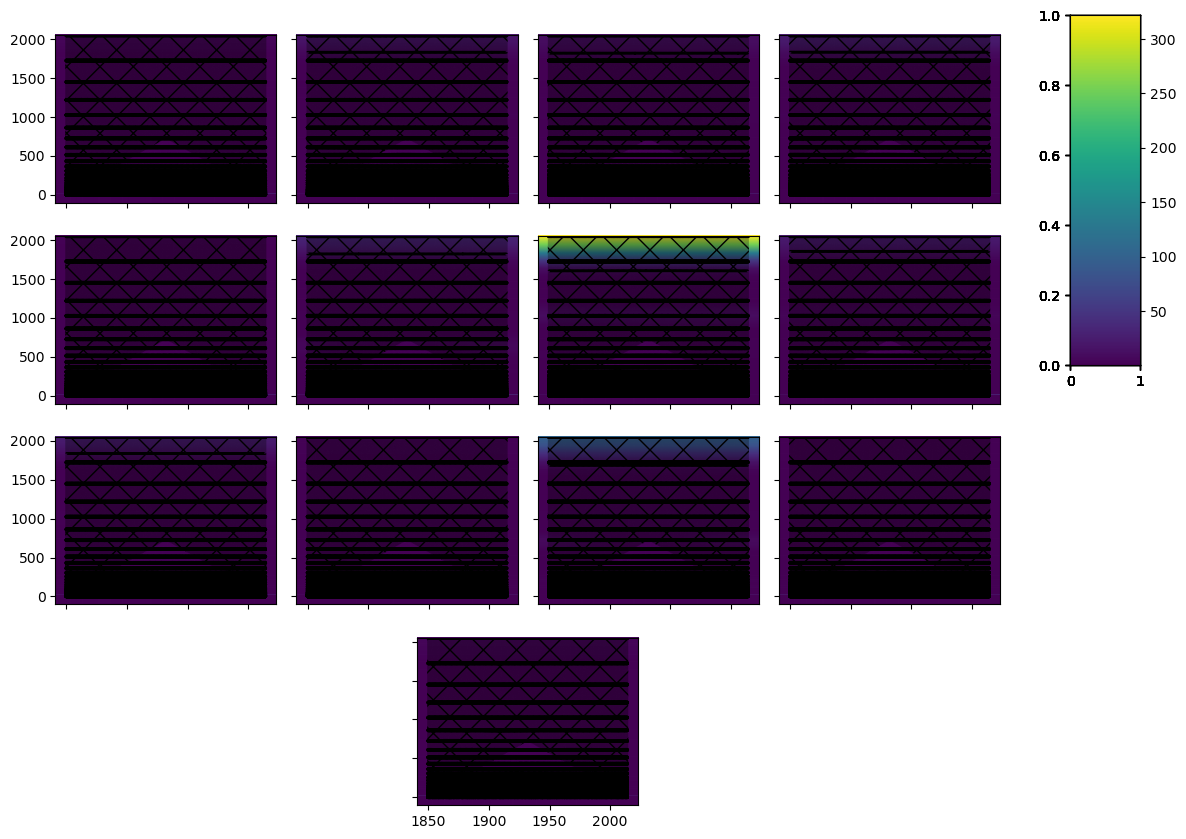

In [20]:
# Plot Cross Wavelet Transform

width_inch = 14
height_inch = 10

fig = plt.figure(figsize=(width_inch, height_inch)) #, constrained_layout=True)
gs = gridspec.GridSpec(4, 8)

for i, ax1 in enumerate(esm):

    if i < 4:
        ax1 = fig.add_subplot(gs[0, 2 * i : 2 * i + 2])
    if ((i > 3) and (i < 8)):
        ax1 = fig.add_subplot(gs[1, 2 * i - 8 : 2 * i - 6])
    if ((i > 7) and (i < 12)):
        ax1 = fig.add_subplot(gs[2, 2 * i - 16 : 2 * i -14])
    if i > 11:
        ax1 = fig.add_subplot(gs[3, 2 * i - 21 : 2 * i -19])


    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.55, 0.05, 0.35])

# Plot Cross-Wavelet

    im1 = NonUniformImage(ax1, interpolation='bilinear', extent=extent_cross_hist[i])
    im1.set_data(t1_hist[i], cross_period_hist[i], cross_power_hist[i])
    ax1.images.append(im1)
    ax1.contour(t1_hist[i], cross_period_hist[i], cross_sig_hist[i], [-99, 1], colors='k', linewidths=2,
                extent=extent_cross_hist[i])
    ax1.fill(np.concatenate([t1_hist[i], t1_hist[i][-1:]+dt, t1_hist[i][-1:]+dt, t1_hist[i][:1]-dt, t1_hist[i][:1]-dt]),
            np.concatenate([cross_coi_hist[i], [1e-9], cross_period_hist[i][-1:],
                            cross_period_hist[i][-1:], [1e-9]]),
            'k', alpha=0.3, hatch='x')
    ax1.quiver(t1_hist[i][::3], cross_period_hist[i][::3], u_hist[i][::3, ::3], v_hist[i][::3, ::3],
            units='width', angles='uv', pivot='mid', linewidth=1,
            edgecolor='k', headwidth=10, headlength=10, headaxislength=5,
            minshaft=2, minlength=5)
    ax1.label_outer()
fig.colorbar(im1, cax=cbar_ax)

# Plot Cross-Correlation

    # im2 = NonUniformImage(ax2, interpolation='bilinear', extent=extent_cor)
    # im2.set_data(t1, cor_period, WCT)
    # ax2.images.append(im2)
    # ax2.contour(t1, cor_period, cor_sig, [-99, 1], colors='k', linewidths=2,
    #             extent=extent_corr)
    # ax2.fill(np.concatenate([t1, t1[-1:]+dt, t1[-1:]+dt, t1[:1]-dt, t1[:1]-dt]),
    #          np.concatenate([cor_coi, [1e-9], cor_period[-1:], cor_period[-1:],
    #                          [1e-9]]),
    #          'k', alpha=0.3, hatch='x')
    # ax2.set_title('Cross-Correlation')
    # ax2.quiver(t1[::3], cor_period[::3], u[::3, ::3], v[::3, ::3], units='height',
    #            angles='uv', pivot='mid', linewidth=1, edgecolor='k',
    #            headwidth=10, headlength=10, headaxislength=5, minshaft=2,
    #            minlength=5)
    # ax2.set_ylim(2, 35)
    # ax2.set_xlim(max(t1.min(), t2.min()), min(t1.max(), t2.max()))
    # fig.colorbar(im2, cax=cbar_ax_1)

plt.draw()
plt.show()

Lagged cross-correlation

In [150]:
s1 = [nino.squeeze().rename(variable = "tos").drop("tos").fillna(nino.mean()) for nino in nino34_hist]
s2 = [pr_hist_amz/]

# s2 = s2[np.argwhere((t2 >= min(t1)) & (t2 <= max(t1))).flatten()]
correlation = [signal.correlate(a, b, mode="full") for a,b in zip(s1,s2)]
correlation = [np.correlate(a, b, "full") for a,b in zip(s1,s2)]
lags = [signal.correlation_lags(a.size, b.size, mode="full") for a,b in zip(s1,s2)]
lag = [l[np.argmax(cor)] for l,cor in zip(lags,correlation)]

# Mediate the response for the esm
correlation = xr_mean_list(xr.DataArray(correlation),files_list)
lags = xr_mean_list(xr.DataArray(lags),files_list)
lag = xr_mean_list(xr.DataArray(lag),files_list)

In [152]:
t1 = s1[0].to_dataframe(name = "tos").drop(columns = ["month"])
t2 = s2[0].to_dataframe().drop(columns = ["region"])

lags = signal.correlation_lags(t1.size, t2.size)


In [153]:
np.correlate(t1, t2, "full")

ValueError: object too deep for desired array

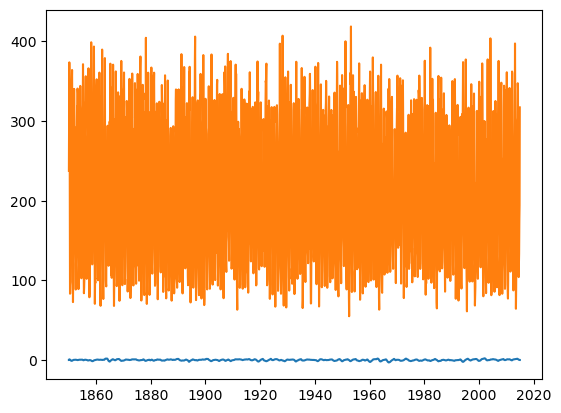

In [157]:
plt.plot(t1)
plt.plot(t2)

(-12.0, 12.0)

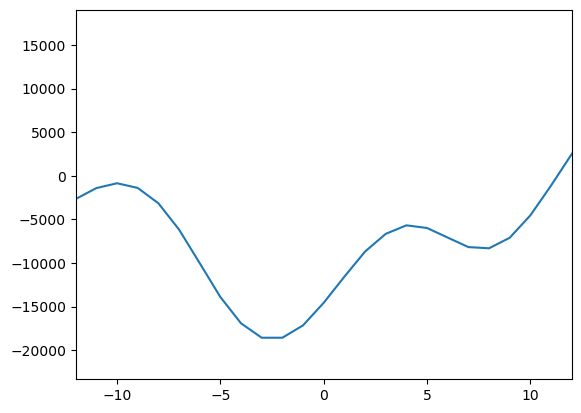

In [151]:
plt.plot(lags[0],correlation[0])
plt.xlim(-12,12)